# Seting up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 3.2 MB/s 
     |████████████████████████████████| 376 kB 18.9 MB/s 
     |████████████████████████████████| 58 kB 5.3 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=78e861416964de0759c282825a0ff1734bcd09e23a3a5aab3f89d872bf314175
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=59d8b8b409787ad5fd1dbae26a4afbf1c67bc760e2057d0314f6e21dd73d594a
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-p3nvhkq1
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-p3nvhkq1
   

# Downloading Dataset




In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 11.76 MiB/s, done.
Resolving deltas: 100% (3/3), done.


# Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

#  Setuping up Configurations

In [36]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'

DEVICE='cuda'

EPOCHS=25

LR=0.003
IMAGE_SIZE=320
BATCH_SIZE=16
ENCODER='timm-regnety_320'
WIEGHTS='imagenet'

In [6]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row=df.iloc[4]
image_path,mask_path=row.images,row.masks

image=cv2.imread(image_path)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE) / 255

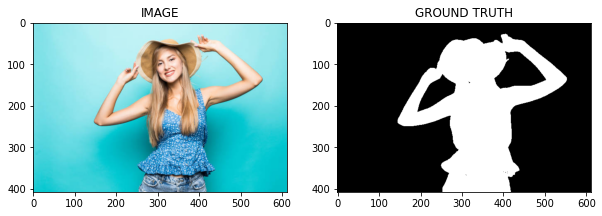

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train ,test=train_test_split(df,test_size=0.2,random_state=42)

#  Augmentation Functions

In [10]:
import albumentations as A

In [11]:
from albumentations.augmentations.transforms import VerticalFlip
def get_train_augs():
  return A.Compose([
        A.Resize(IMAGE_SIZE,IMAGE_SIZE),
        A.HorizontalFlip(p= 0.5),
        A.VerticalFlip(p=0.5)
  ])
def get_test_augs():
  return A.Compose([
        A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ])

# Creating Custom Dataset 

In [12]:

from torch.utils.data import Dataset

In [13]:
class dataset_seg(Dataset):
  "Segmenting the data "
  def __init__(self,df , augmentations):
    self.df=df
    self.augmentations= augmentations 

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row=self.df.iloc[idx]

    image_path=row.images
    mask_path=row.masks

    image =cv2.imread(image_path,1)
    image =cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

    mask= cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask= np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data= self.augmentations(image= image ,mask= mask)
      image=data['image']
      mask= data['mask']
    
    # changing the indexs of images from (Hieght,width,channel) to (channel, hieght, width)
    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask= np.transpose(mask, (2,0,1)).astype(np.float32)

    # converting images to tensors between 0 and 1  and rounding the mask to either  
    image=torch.tensor(image) / 255.0
    mask= torch.round( torch.tensor(mask) /255.0) 
  
    return image, mask

In [14]:
trainset=dataset_seg(train,get_train_augs())
testset= dataset_seg(test, get_test_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of testset : {len(testset)}")

Size of Trainset : 232
Size of testset : 58


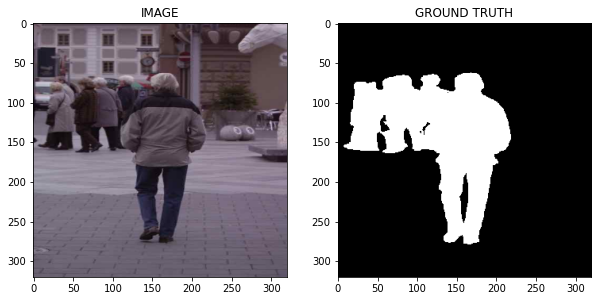

In [16]:
idx=35
image , mask= trainset[idx]
helper.show_image(image,mask)

#  Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
train_loader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
test_loader=DataLoader(testset,batch_size=BATCH_SIZE,shuffle=True)


In [19]:
print (f"total NO of Batches in trainloader: {len(train_loader)}")
print (f"total NO of Batches in testloader: {len(test_loader)}")

total NO of Batches in trainloader: 15
total NO of Batches in testloader: 4


In [20]:
for image ,mask in train_loader:
  break
print (f'one batch image shape :{image.shape} ')
print (f'one batch mask shape :{mask.shape} ')

one batch image shape :torch.Size([16, 3, 320, 320]) 
one batch mask shape :torch.Size([16, 1, 320, 320]) 


#  Creating  Segmentation Model

In [21]:
from torch import nn 
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):

  def __init__(self):
    # declaring a super class for the model 
    super(SegmentationModel,self).__init__()
    #declaring the Model arc 
    self.arc= smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WIEGHTS,
        in_channels=3,
        classes = 1,
        activation = None 
    )

  def forward(self, images, masks=None):
    #defining the loss 
    logits=self.arc(images)

    if masks!=None: 
      #Calculating the Loss 
      loss1= DiceLoss(mode='binary')(logits,masks)
      loss2= nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1 + loss2

    return logits 

In [23]:
model=SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

#  Creating Train and Validation Functions

In [24]:
def train_fn(data_loader, model , optimizer) :
 # TRAINING THE MODEL 
  model.train()
  #DEFINING THE LOSS AT 0.0 
  total_loss=0.0
  # DOWNLOADING THE IMAGES AND MASKS TO DEVICE 
  for images, masks in tqdm(data_loader):
    images= images.to(DEVICE)
    masks= masks.to(DEVICE)

    #INITIATING THE OPTIMIZER
    optimizer.zero_grad()
    #EXTRACTING THE LOGITS AND LOSS 
    logits , loss= model(images ,masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(data_loader)

def test_fn(data_loader, model) :
  model.eval()
  total_loss=0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images= images.to(DEVICE)
      masks= masks.to(DEVICE)

      
      logits, loss= model(images,masks)

      total_loss += loss.item()
  return total_loss / len(data_loader)
  

# Train Model

In [25]:
optimizer= torch.optim.Adam(model.parameters(),lr=LR)

In [37]:
best_valid_loss=np.Inf

for i in range(EPOCHS):
  train_loss= train_fn(train_loader, model, optimizer)
  valid_loss=test_fn(test_loader,model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model')
    print('Model_saved')

    best_valid_loss=valid_loss
  print(f'Epoch : {i+1} train_loss: {train_loss} Validation Loss {valid_loss}')


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Model_saved
Epoch : 1 train_loss: 0.10108938564856847 Validation Loss 0.16946575790643692


100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


Epoch : 2 train_loss: 0.10035902311404546 Validation Loss 0.17273575067520142


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Model_saved
Epoch : 3 train_loss: 0.1027035449941953 Validation Loss 0.15690964832901955


100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


Model_saved
Epoch : 4 train_loss: 0.09862596740325293 Validation Loss 0.142340037971735


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


Epoch : 5 train_loss: 0.10496130337317784 Validation Loss 0.18555569648742676


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


Epoch : 6 train_loss: 0.09256737033526102 Validation Loss 0.15712356567382812


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Epoch : 7 train_loss: 0.08606743936737378 Validation Loss 0.17620350420475006


100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


Epoch : 8 train_loss: 0.08708343158165614 Validation Loss 0.17957138642668724


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Epoch : 9 train_loss: 0.07658733526865641 Validation Loss 0.17850958928465843


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


Epoch : 10 train_loss: 0.077200036495924 Validation Loss 0.16785838454961777


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


Epoch : 11 train_loss: 0.07865260789791743 Validation Loss 0.20115600153803825


100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


Epoch : 12 train_loss: 0.1042460689942042 Validation Loss 0.2819581590592861


100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


Epoch : 13 train_loss: 0.13857297698656718 Validation Loss 0.21552948653697968


100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


Epoch : 14 train_loss: 0.16293190866708757 Validation Loss 0.27824942022562027


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Epoch : 15 train_loss: 0.16988347470760345 Validation Loss 0.21186307072639465


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


Epoch : 16 train_loss: 0.13597250431776048 Validation Loss 0.21711565926671028


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


Epoch : 17 train_loss: 0.10912229965130488 Validation Loss 0.1856738068163395


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


Epoch : 18 train_loss: 0.08943603833516439 Validation Loss 0.18180880323052406


100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


Epoch : 19 train_loss: 0.08389196991920471 Validation Loss 0.15459471195936203


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Epoch : 20 train_loss: 0.0880653162797292 Validation Loss 0.1781613901257515


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Epoch : 21 train_loss: 0.0856817881266276 Validation Loss 0.17410940676927567


100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


Epoch : 22 train_loss: 0.0772319513062636 Validation Loss 0.17862678319215775


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


Epoch : 23 train_loss: 0.0745310162504514 Validation Loss 0.16470081731677055


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Epoch : 24 train_loss: 0.0722934735318025 Validation Loss 0.17577010206878185


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

Epoch : 25 train_loss: 0.08366155475378037 Validation Loss 0.183130644261837


# **Inference**

In [40]:
import logging
idx= 20 

model.load_state_dict(torch.load('/content/best_model'))
image , mask = testset[idx]
logits_mask= model(image.to(DEVICE).unsqueeze(0)) #(Channel,Hieght,Weight)=> (1,channel,hieght,weight)

pred_mask= torch.sigmoid(logits_mask)
pred_mask=(pred_mask > 0.05)*1.0


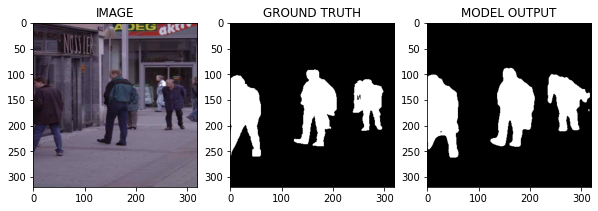

In [41]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))